In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import difflib
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
from nltk.stem.porter import *
import time 

In [2]:
# Read the product data with cleaned attribute value (duplicates already dropped)
data1 = pd.read_csv('data1.csv',encoding='utf8')

/Users/dakotawu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Read the sentence vector
product_lem_vector = pd.read_csv('sentence vector.csv')
product_lem_vector.drop(columns=['Unnamed: 0'],inplace=True)
product_lem_vector.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.195374,-0.281851,0.304882,0.317905,-0.566659,0.144472,0.338423,0.466763,-0.308142,-0.422603,...,0.040947,0.144709,-0.892435,0.221310,0.231519,0.093096,-0.036873,-0.016860,-0.633326,-0.253246
1,0.362074,-0.054334,-0.074113,-0.168102,0.262178,-0.345002,-0.235304,0.595841,0.304812,-0.039476,...,-0.035365,0.274454,-0.231328,0.518057,0.076834,0.160487,0.016917,0.197333,-0.257891,-0.041439
2,0.362074,-0.054334,-0.074113,-0.168102,0.262178,-0.345002,-0.235304,0.595841,0.304812,-0.039476,...,-0.035365,0.274454,-0.231328,0.518057,0.076834,0.160487,0.016917,0.197333,-0.257891,-0.041439
3,0.430411,-0.328558,-0.039912,-0.045958,0.296938,-0.313831,-0.195081,0.601441,-0.048300,-0.213406,...,0.084220,0.295986,-0.275193,0.492814,0.337529,0.529874,0.100594,0.035841,-0.143301,-0.122036
4,0.424296,-0.059973,-0.041524,0.147223,0.135762,0.018363,-0.074382,0.446825,-0.174599,-0.727291,...,0.282489,0.024574,-0.362016,0.539296,0.088323,0.584191,-0.374095,0.022752,-0.336074,-0.246386


In [4]:
# Turn the panda series into a list of arrays
product_lem_vector = np.array(product_lem_vector)
product_lem_vector = list(product_lem_vector)

# Model Building + Sample Prediction

In [5]:
# Get all unique attribute values for each attribute
unique_attribute_value = {}
for attr in ['occasion', 'style', 'subcategory_bottom', 'subcategory_top']:
    temp = data1[data1['attribute_name']==attr]
    temp_value = []
    for value in temp['new_attribute_value'].unique():
        temp_value.append(value)
    unique_attribute_value[attr] = temp_value

In [6]:
# Tag products based on cosine similarities
def tagging(product):
    import scipy
#    product_tag = pd.Series()
    product_tag = []
    for attr in ['occasion', 'style', 'subcategory_bottom', 'subcategory_top']:
        similarities = []
        df = data1[data1['attribute_name']==attr]
        for index in df.index:
            item = product_lem_vector[index]
            similarity = 1 - scipy.spatial.distance.cosine(product,item)
            similarities.append(similarity)
        similarities = pd.DataFrame(similarities,index=df.index,columns=['score'])
        similarities = similarities[similarities.score<0.999999999]
        if attr in ['occasion','style']:
            tags = set()
            for index in similarities[similarities.score>=0.8].index:
                tags.add(data1.loc[index,'new_attribute_value'])
#            product_tag[attr] = list(tags)
            for tag in tags:
                product_tag.append([attr,tag])
        else:
            if similarities.score.max()<0.8:
#                product_tag[attr] = 'N/A'
                product_tag.append([attr,'N/A'])
            else:
                index = similarities.idxmax()
                tag = data1.loc[index,'new_attribute_value'].values
#                product_tag[attr] = tag
                product_tag.append([attr,tag])
    product_tag = pd.DataFrame(product_tag,columns=['attribute_name','attribute_value'])
    return product_tag

In [7]:
# Tag 100 products in the dataset

# Randomly sample 100 products 
tic = time.time()

products = pd.Series(data1.product_id.unique())
sample = pd.Series(products.sample(n=100,random_state=1))

# Predict 
prediction = pd.DataFrame()
for index in sample.index:
    new_product = product_lem_vector[index]
    temp = tagging(new_product)
    temp['product_id'] = data1.loc[index,'product_id']
    prediction = prediction.append(temp,sort=False)
prediction.columns = ['attribute_name','predicted_attribute_value','product_id']

toc = time.time()

print(f'Total elapsed time: {toc-tic} seconds')

Total elapsed time: 234.12811923027039 seconds


In [8]:
prediction

,attribute_name,predicted_attribute_value,product_id
0,occasion,workout,01DPGV907RVE6WXD00BN285VQV
1,occasion,daytonight,01DPGV907RVE6WXD00BN285VQV
2,occasion,weekend,01DPGV907RVE6WXD00BN285VQV
3,occasion,vacation,01DPGV907RVE6WXD00BN285VQV
4,occasion,work,01DPGV907RVE6WXD00BN285VQV
5,occasion,nightout,01DPGV907RVE6WXD00BN285VQV
6,style,romantic,01DPGV907RVE6WXD00BN285VQV
7,style,businesscasual,01DPGV907RVE6WXD00BN285VQV
8,style,glam,01DPGV907RVE6WXD00BN285VQV
9,style,boho,01DPGV907RVE6WXD00BN285VQV


In [9]:
# Calculate Recall, Precision, F1 score for each attribute value
tic = time.time()

test_data = data1[data1['product_id'].isin(prediction['product_id'].unique())]
result = []
for key in unique_attribute_value.keys():
    for value in unique_attribute_value[key]:
        Actual_P = test_data[(test_data['attribute_name']==key)&\
                             (test_data['new_attribute_value']==value)]\
                            [['attribute_name','new_attribute_value','product_id']]
        Predicted_P = prediction[(prediction['attribute_name']==key)&\
                                 (prediction['predicted_attribute_value']==value)]\
                                [['attribute_name','predicted_attribute_value','product_id']]
        TP = Actual_P.merge(Predicted_P)
        if Actual_P.shape[0]==0:
            continue 
        elif Predicted_P.shape[0]==0:
            continue 
        elif TP.shape[0]==0:
            Recall = 0
            Precision = 0
            F1 = 0
        else:
            Recall = TP.shape[0]/Actual_P.shape[0]
            Precision = TP.shape[0]/Predicted_P.shape[0]
            F1 = 2*Precision*Recall/(Precision+Recall)
            result.append([key,value,Recall,Precision,F1])
result = pd.DataFrame(result,columns=['attribute_name','attribute_value','recall','precision','f1'])

toc = time.time()
print(f'Total elapsed time: {toc-tic} seconds')

Total elapsed time: 0.5852370262145996 seconds


# Threshold tuning 

In [11]:
# Tag products based on cosine similarities
def tagging(product):
    import scipy
#    product_tag = pd.Series()
    product_tag = []
    for attr in ['occasion', 'style', 'subcategory_bottom', 'subcategory_top']:
        similarities = []
        df = data1[data1['attribute_name']==attr]
        for index in df.index:
            item = product_lem_vector[index]
            similarity = 1 - scipy.spatial.distance.cosine(product,item)
            similarities.append(similarity)
        similarities = pd.DataFrame(similarities,index=df.index,columns=['score'])
        similarities = similarities[similarities.score<0.999999999]
        if attr in ['occasion','style']:
            tags = set()
            for index in similarities[similarities.score>=t1].index:
                tags.add(data1.loc[index,'new_attribute_value'])
#            product_tag[attr] = list(tags)
            for tag in tags:
                product_tag.append([attr,tag])
        else:
            if similarities.score.max()<t2:
#                product_tag[attr] = 'N/A'
                product_tag.append([attr,'N/A'])
            else:
                index = similarities.idxmax()
                tag = data1.loc[index,'new_attribute_value'].values
#                product_tag[attr] = tag
                product_tag.append([attr,tag])
    product_tag = pd.DataFrame(product_tag,columns=['attribute_name','attribute_value'])
    return product_tag

In [12]:
tic = time.time()

final_result = pd.DataFrame()
for t1 in [0.6,0.7,0.8,0.9]:
    for t2 in [0.6,0.7,0.8,0.9]:
        products = pd.Series(data1.product_id.unique())
        sample = pd.Series(products.sample(n=100,random_state=1))

        prediction = pd.DataFrame()
        for index in sample.index:
            new_product = product_lem_vector[index]
            temp = tagging(new_product)
            temp['product_id'] = data1.loc[index,'product_id']
            prediction = prediction.append(temp,sort=False)
        prediction.columns = ['attribute_name','predicted_attribute_value','product_id']

        test_data = data1[data1['product_id'].isin(prediction['product_id'].unique())]
        result = []
        for key in unique_attribute_value.keys():
            for value in unique_attribute_value[key]:
                Actual_P = test_data[(test_data['attribute_name']==key)&\
                                     (test_data['new_attribute_value']==value)]\
                                    [['attribute_name','new_attribute_value','product_id']]
                Predicted_P = prediction[(prediction['attribute_name']==key)&\
                                         (prediction['predicted_attribute_value']==value)]\
                                        [['attribute_name','predicted_attribute_value','product_id']]
                TP = Actual_P.merge(Predicted_P)
                if Actual_P.shape[0]==0:
                    continue 
                elif Predicted_P.shape[0]==0:
                    continue 
                elif TP.shape[0]==0:
                    Recall = 0
                    Precision = 0
                    F1 = 0
                else:
                    Recall = TP.shape[0]/Actual_P.shape[0]
                    Precision = TP.shape[0]/Predicted_P.shape[0]
                    F1 = 2*Precision*Recall/(Precision+Recall)
                    result.append([key,value,Recall,Precision,F1])
        result = pd.DataFrame(result,columns=['attribute_name','attribute_value','recall','precision','f1'])
        result['t1'] = t1
        result['t2'] = t2
        final_result = pd.concat([final_result,result],ignore_index=True)
            
toc = time.time()

print(f'Total elapsed time: {toc-tic} seconds')

Total elapsed time: 2682.66454911232 seconds


Text(0, 0.5, 'F1 Score')

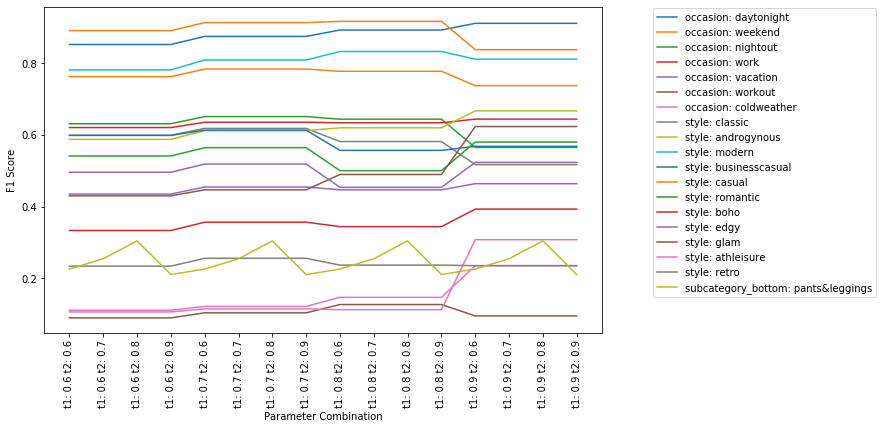

In [20]:
import matplotlib.pyplot as plt
final_result['attribute'] = final_result['attribute_name']+": "+final_result['attribute_value']
final_result['thresholds'] = 't1:'+' '+final_result['t1'].astype('str')+' '+'t2:'+' '+final_result['t2'].astype('str')

plt.figure(figsize=(10,6))
for attr in final_result['attribute'].unique():
    temp = final_result[final_result['attribute']==attr]
    plt.plot(temp['thresholds'],temp['f1'],label=attr)
plt.legend(loc='best', bbox_to_anchor=(1, 0.51, 0.5, 0.5))
plt.xticks(final_result['thresholds'].unique(),rotation=90)
plt.xlabel('Parameter Combination')
plt.ylabel('F1 Score')

# Threshold tuning using TF-IDF weighted vector

In [16]:
# Read the sentence vector
product_lem_weighted = pd.read_csv('weighted vector.csv')
product_lem_weighted.drop(columns=['Unnamed: 0'],inplace=True)
product_lem_weighted.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.000921,0.262938,0.007765,0.076936,0.088947,0.049776,-0.166840,-0.034382,-0.138464,0.858046,...,-0.117406,0.073373,0.122307,-0.374769,-0.151006,0.052971,-0.150931,0.022538,0.015760,-0.032191
1,0.134290,0.117079,-0.235173,0.218606,0.304716,0.067915,0.143959,0.192588,0.126419,0.846576,...,0.039377,0.214120,0.005498,-0.083538,-0.187681,-0.200719,-0.096517,0.124532,0.211103,-0.013291
2,0.134290,0.117079,-0.235173,0.218606,0.304716,0.067915,0.143959,0.192588,0.126419,0.846576,...,0.039377,0.214120,0.005498,-0.083538,-0.187681,-0.200719,-0.096517,0.124532,0.211103,-0.013291
3,0.034654,0.299562,-0.224840,-0.036511,0.108815,-0.101901,0.070708,-0.015759,-0.061147,1.150876,...,-0.066309,0.152449,0.240468,-0.152140,-0.205784,-0.012812,-0.096164,-0.097580,0.156453,0.053204
4,-0.055500,0.067927,-0.231411,0.110976,0.080236,0.051358,0.022078,-0.041819,-0.123866,1.119662,...,-0.016919,0.118934,0.043433,-0.181443,-0.156180,0.001597,-0.023341,0.083377,0.213422,-0.034693


In [17]:
# Turn the panda series into a list of arrays
product_lem_weighted = np.array(product_lem_weighted)
product_lem_weighted = list(product_lem_weighted)

In [18]:
# In order to not rewrite the code below, I change the weighted vector name to "product_lem_vector"
product_lem_vector = product_lem_weighted

In [26]:
# I deceased the number of parameter combinations due to time constraint 
tic = time.time()

final_result_weighted = pd.DataFrame()
for t1 in [0.7,0.8,0.9]:
    for t2 in [0.7,0.8,0.9]:
        products = pd.Series(data1.product_id.unique())
        sample = pd.Series(products.sample(n=100,random_state=1))

        prediction = pd.DataFrame()
        for index in sample.index:
            new_product = product_lem_vector[index]
            temp = tagging(new_product)
            temp['product_id'] = data1.loc[index,'product_id']
            prediction = prediction.append(temp,sort=False)
        prediction.columns = ['attribute_name','predicted_attribute_value','product_id']

        test_data = data1[data1['product_id'].isin(prediction['product_id'].unique())]
        result = []
        for key in unique_attribute_value.keys():
            for value in unique_attribute_value[key]:
                Actual_P = test_data[(test_data['attribute_name']==key)&\
                                     (test_data['new_attribute_value']==value)]\
                                    [['attribute_name','new_attribute_value','product_id']]
                Predicted_P = prediction[(prediction['attribute_name']==key)&\
                                         (prediction['predicted_attribute_value']==value)]\
                                        [['attribute_name','predicted_attribute_value','product_id']]
                TP = Actual_P.merge(Predicted_P)
                if Actual_P.shape[0]==0:
                    continue 
                elif Predicted_P.shape[0]==0:
                    continue 
                elif TP.shape[0]==0:
                    Recall = 0
                    Precision = 0
                    F1 = 0
                else:
                    Recall = TP.shape[0]/Actual_P.shape[0]
                    Precision = TP.shape[0]/Predicted_P.shape[0]
                    F1 = 2*Precision*Recall/(Precision+Recall)
                    result.append([key,value,Recall,Precision,F1])
        result = pd.DataFrame(result,columns=['attribute_name','attribute_value','recall','precision','f1'])
        result['t1'] = t1
        result['t2'] = t2
        final_result_weighted = pd.concat([final_result,result],ignore_index=True)
            
toc = time.time()

print(f'Total elapsed time: {toc-tic} seconds')

/Users/dakotawu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Total elapsed time: 1338.529065132141 seconds


/Users/dakotawu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/dakotawu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0, 0.5, 'F1 Score')

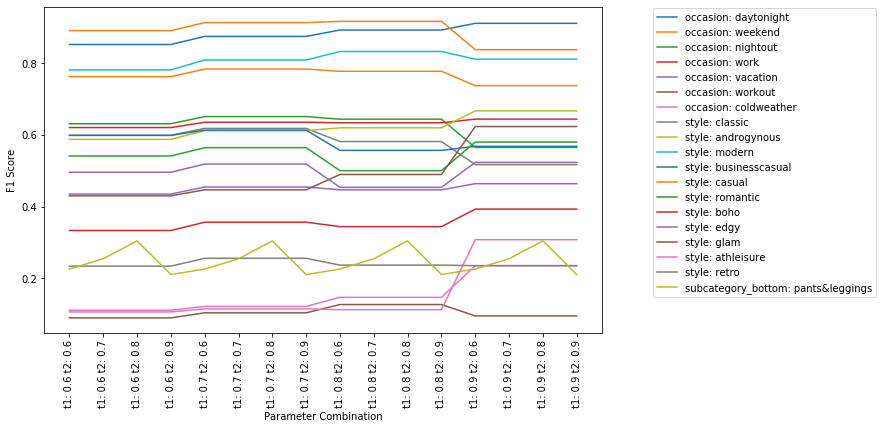

In [32]:
import matplotlib.pyplot as plt
final_result_weighted = final_result_weighted.dropna(axis=0)
final_result_weighted['attribute'] = final_result_weighted['attribute_name']+": "+\
                                     final_result_weighted['attribute_value']
final_result_weighted['thresholds'] = 't1:'+' '+final_result_weighted['t1'].astype('str')+' '+'t2:'+' '+\
                                      final_result_weighted['t2'].astype('str')

plt.figure(figsize=(10,6))
for attr in final_result_weighted['attribute'].unique():
    temp = final_result_weighted[final_result_weighted['attribute']==attr]
    plt.plot(temp['thresholds'],temp['f1'],label=attr)
plt.legend(loc='best', bbox_to_anchor=(1, 0.51, 0.5, 0.5))
plt.xticks(final_result_weighted['thresholds'].unique(),rotation=90)
plt.xlabel('Parameter Combination')
plt.ylabel('F1 Score')

# Threshold tuning using TF-IDF

In [33]:
# Read the TF-IDF file
tf_idf = pd.read_csv('combine_lem_tfidf_score.csv')
tf_idf.drop(columns=['Unnamed: 0'],inplace=True)
tf_idf.head()

,accent,acetate,across,add,adjustable,allover,along,also,anine,ankle,...,wool,work,world,worn,woven,wrap,xx,yellow,zip,zipper
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110332,0.0


In [34]:
# Turn the panda series into a list of arrays
tf_idf = np.array(tf_idf)
tf_idf = list(tf_idf)

In [35]:
# In order to not rewrite the code below, I change the TF-IDF vector name to "product_lem_vector"
product_lem_vector = tf_idf

In [37]:
# I deceased the number of parameter combinations due to time constraint 
tic = time.time()

final_result_tfidf = pd.DataFrame()
for t1 in [0.7,0.8,0.9]:
    for t2 in [0.7,0.8,0.9]:
        products = pd.Series(data1.product_id.unique())
        sample = pd.Series(products.sample(n=100,random_state=1))

        prediction = pd.DataFrame()
        for index in sample.index:
            new_product = product_lem_vector[index]
            temp = tagging(new_product)
            temp['product_id'] = data1.loc[index,'product_id']
            prediction = prediction.append(temp,sort=False)
        prediction.columns = ['attribute_name','predicted_attribute_value','product_id']

        test_data = data1[data1['product_id'].isin(prediction['product_id'].unique())]
        result = []
        for key in unique_attribute_value.keys():
            for value in unique_attribute_value[key]:
                Actual_P = test_data[(test_data['attribute_name']==key)&\
                                     (test_data['new_attribute_value']==value)]\
                                    [['attribute_name','new_attribute_value','product_id']]
                Predicted_P = prediction[(prediction['attribute_name']==key)&\
                                         (prediction['predicted_attribute_value']==value)]\
                                        [['attribute_name','predicted_attribute_value','product_id']]
                TP = Actual_P.merge(Predicted_P)
                if Actual_P.shape[0]==0:
                    continue 
                elif Predicted_P.shape[0]==0:
                    continue 
                elif TP.shape[0]==0:
                    Recall = 0
                    Precision = 0
                    F1 = 0
                else:
                    Recall = TP.shape[0]/Actual_P.shape[0]
                    Precision = TP.shape[0]/Predicted_P.shape[0]
                    F1 = 2*Precision*Recall/(Precision+Recall)
                    result.append([key,value,Recall,Precision,F1])
        result = pd.DataFrame(result,columns=['attribute_name','attribute_value','recall','precision','f1'])
        result['t1'] = t1
        result['t2'] = t2
        final_result_tfidf = pd.concat([final_result,result],ignore_index=True)
            
toc = time.time()

print(f'Total elapsed time: {toc-tic} seconds')

/Users/dakotawu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Total elapsed time: 1494.9715859889984 seconds


/Users/dakotawu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/dakotawu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0, 0.5, 'F1 Score')

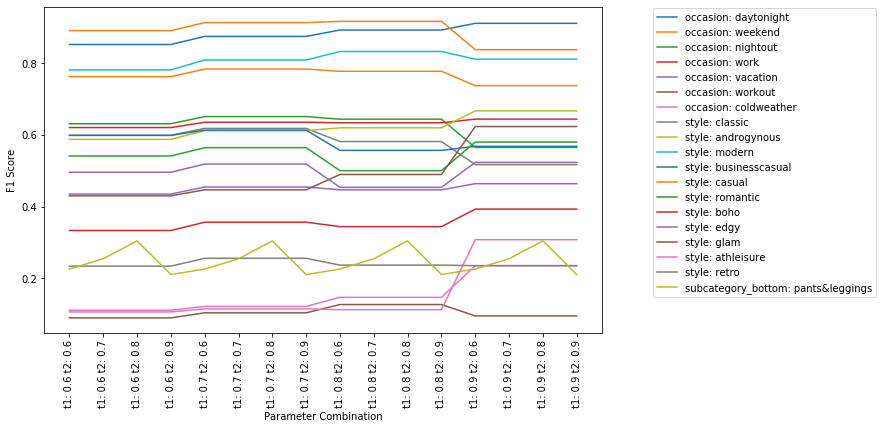

In [39]:
import matplotlib.pyplot as plt
final_result_tfidf = final_result_tfidf.dropna(axis=0)
final_result_tfidf['attribute'] = final_result_tfidf['attribute_name']+": "+\
                                     final_result_tfidf['attribute_value']
final_result_tfidf['thresholds'] = 't1:'+' '+final_result_tfidf['t1'].astype('str')+' '+'t2:'+' '+\
                                      final_result_tfidf['t2'].astype('str')

plt.figure(figsize=(10,6))
for attr in final_result_tfidf['attribute'].unique():
    temp = final_result_tfidf[final_result_tfidf['attribute']==attr]
    plt.plot(temp['thresholds'],temp['f1'],label=attr)
plt.legend(loc='best', bbox_to_anchor=(1, 0.51, 0.5, 0.5))
plt.xticks(final_result_tfidf['thresholds'].unique(),rotation=90)
plt.xlabel('Parameter Combination')
plt.ylabel('F1 Score')

# Final Model Selection

Based on the three graphs shown above, the prediction results are similar for three kinds of input. After analyzing the graphs, I decided to pick t1 = 0.7 and t2 = 0.8 as the model parameters. 

In [69]:
def tagging_final(product,data1,product_lem_vector):
    import scipy
    
    product_tag = pd.DataFrame()
#    product_tag = pd.Series()
#    product_tag = []
    for attr in ['occasion', 'style', 'subcategory_bottom', 'subcategory_top']:
        similarities = []
        df = data1[data1['attribute_name']==attr]
        for index in df.index:
            item = product_lem_vector[index]
            similarity = 1 - scipy.spatial.distance.cosine(product,item)
            similarities.append(similarity)
        similarities = pd.DataFrame(similarities,index=df.index,columns=['score'])
        similarities = similarities[similarities.score<0.999999999]
        if attr in ['occasion','style']:
            tags = set()
            for index in similarities[similarities.score>=0.8].index:
                tags.add(data1.loc[index,'new_attribute_value'])
            product_tag[attr] = [list(tags)]
#            for tag in tags:
#                product_tag.append([attr,tag])
        else:
            if similarities.score.max()<0.8:
                product_tag[attr] = 'N/A'
#                product_tag.append([attr,'N/A'])
            else:
                index = similarities.idxmax()
                tag = data1.loc[index,'new_attribute_value'].values
                product_tag[attr] = tag
#                product_tag.append([attr,tag])
#    product_tag = pd.DataFrame(product_tag,columns=['attribute_name','attribute_value'])
    return product_tag

In [55]:
# Read the sentence vector
product_lem_vector = pd.read_csv('sentence vector.csv')
product_lem_vector.drop(columns=['Unnamed: 0'],inplace=True)
product_lem_vector.head()
# Turn the panda series into a list of arrays
product_lem_vector = np.array(product_lem_vector)
product_lem_vector = list(product_lem_vector)
# Read data1
data1 = pd.read_csv('data1.csv')

In [70]:
t1 = 0.6
t2 = 0.6
testing = product_lem_vector[0]
tagging_final(testing)

,occasion,style,subcategory_bottom,subcategory_top
0,"[workout, daytonight, weekend, vacation, work,...","[romantic, businesscasual, glam, boho, classic...",N/A,N/A
